# P-values for simple binned cut-and-count experiments

Here, we perform a simple cut and count experiment, drawing data from a 2D Gaussian. Binning the distributions we calculate the expectation value per pin using the pdf of the distribution (i.e. oversampling infinitely) and use Poisson statistics to obtain the significance.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal 
import scipy.stats as stats
import tqdm
from sklearn.ensemble import HistGradientBoostingClassifier

In [3]:
plt.rcParams['pgf.rcfonts'] = False
plt.rcParams['font.serif'] = []
plt.rcParams['text.usetex'] = True
#plt.rcParams['figure.figsize'] = 3.5, 2.625
plt.rcParams['axes.formatter.useoffset'] = False
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['errorbar.capsize'] = 2
plt.rcParams['grid.linewidth'] = 0.5
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.title_fontsize'] = 12
plt.rcParams['legend.fontsize'] = 12
#plt.rcParams['legend.frameon'] = False

First we define some helper functions including one generating the data, one calculating p-values from significances and one (with its own helper function) calculating the significances themselves using the Asimov estimate.

In [ ]:
def draw_data(N_data= 10000, mu=[0,0], sigma=[[1,0],[0,1]]):
    rv = multivariate_normal(mu, sigma)
    return  rv.rvs(mu, sigma, size=N_data), rv

def get_p_value(sig):
    return 2*(1-stats.norm.cdf(sig))

def p_value_poissonpoisson_2tailed(N_data, N_BT, k=0.5):
    p_value = 1-stats.nbinom.cdf(N_data-1, N_BT, k)
    p_left = stats.nbinom.cdf(N_data, N_BT, 0.5)
    return np.min(np.array([p_value, p_left]), axis=0)*2

def p_value_poissonpoisson(N_data, N_BT, k=0.5):
    #a = 1-stats.nbinom.cdf(N_BT-1, N_data, k)
    #b = 1-stats.nbinom.cdf(N_data-1, N_BT, k)
    #inds = np.where(N_data>N_BT, 0, 1)
    #return inds*a +(1-inds)*b

    #if N_data < N_BT:
    #    return 1-stats.nbinom.cdf(N_BT-1, N_data, k)
    return 1-stats.nbinom.cdf(N_data-1, N_BT, k)

def p_value_poisson(N_data, N_BT):
    return 1-stats.poisson.cdf(N_data-1, N_BT)

def p_value_binomial(N_data, N_BT, N_total):
    return 1-stats.binom.cdf(N_data-1, N_total, N_BT/N_total)

def sig(N, b, err):
    """
    Complicated significance formula calculation where N=N_obs, b = N_exp and err=delta_sys
    """
    if err==0:
        s=N-b
        x=N*np.log(1+s/b)-s
        x[x<0]=0
        return np.sqrt(2*(x))
    s = N - b
    ln1 = N * (b+err**2) / (b**2+N*err**2)
    ln1 = 2 * N * np.log(ln1)

    ln2 = 1 + err**2 * s / b / (b+err**2)
    ln2 = 2 * b**2 / err**2 * np.log(ln2)
    x = ln1 - ln2
    x[x<0]=0
    return np.sqrt(x)

def significance_formula(N_data, N_BT):
    return sig(N_data, N_BT, 0)

def significance_naive(N_data, N_BT):
    return (N_data-N_BT)/np.sqrt(N_BT)

In [5]:
def do_test(N_tests, bins, N, bins_edge = None):
    rv = multivariate_normal([0,0], [[1,0],[0,1]])
    if bins_edge is None:
        edges = np.histogramdd(rv.rvs(size=100000), bins=bins)[1]
    else:
        edges = [np.linspace(-2,2,bins+1), np.linspace(-bins_edge,bins_edge,bins+1)]

    exp = np.zeros((bins,bins))
    for i in range(bins):
        for j in range(bins):
            exp[i,j] = (rv.cdf([edges[0][i+1], edges[1][j+1]])+rv.cdf([edges[0][i], edges[1][j]]) - rv.cdf([edges[0][i+1], edges[1][j]])-rv.cdf([edges[0][i], edges[1][j+1]]))*N

    p_poisson = np.zeros((bins,bins, N_tests))
    p_binomial = np.zeros((bins,bins, N_tests))
    for k in tqdm.tqdm(range(N_tests)):
        data = rv.rvs(size=N, random_state=k)
        hist = np.histogramdd(data, bins=edges)[0]
        p_poisson[:,:, k] = p_value_poisson(hist, exp)
        p_binomial[:,:,k] = p_value_binomial(hist, exp, N)
    return p_poisson, p_binomial       

100%|██████████| 100000/100000 [02:02<00:00, 814.20it/s]


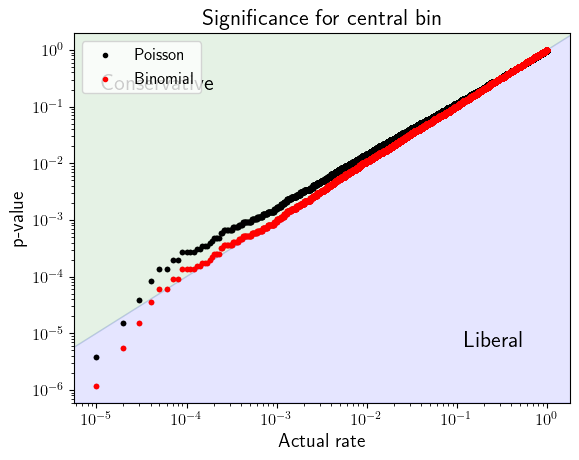

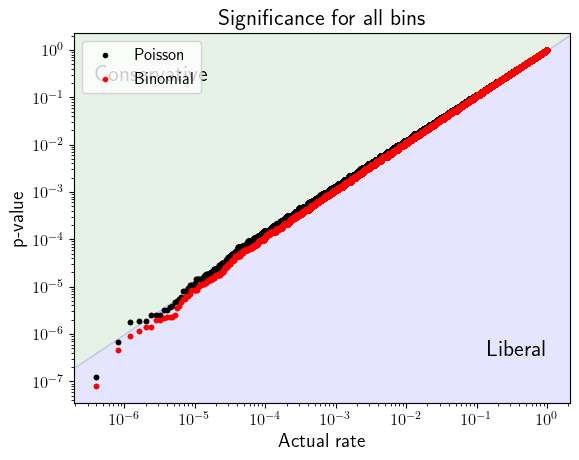

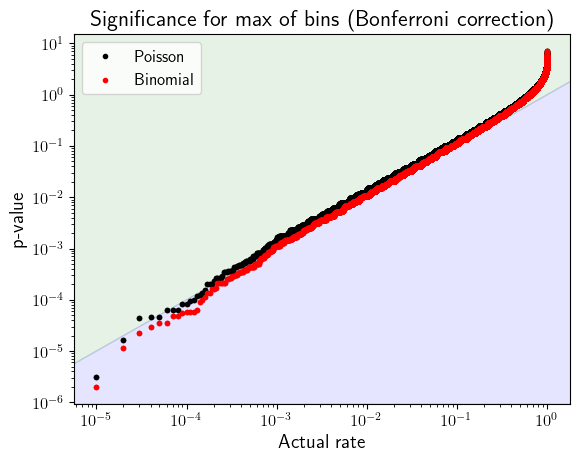

In [8]:
bins = 5
N_tests = 100000
N = 10000
bins_edge = 2
p_poisson, p_binomial = do_test(N_tests, bins, N, bins_edge = bins_edge)

#Plot for central bin only
bin_plot = int((bins-1)/2)
plt.figure()
plt.title("Significance for central bin")
plt.ylabel("p-value")
plt.xlabel("Actual rate")
plt.xscale("log")
plt.yscale("log")

counts = np.arange(1, N_tests+1)

plt.scatter(counts/N_tests, np.sort(p_poisson[bin_plot, bin_plot]), marker = '.', color="black")
plt.scatter(counts/N_tests, np.sort(p_binomial[bin_plot, bin_plot]), marker = '.', color="red")
xmin, xmax = plt.xlim()
ymin, ymax = plt.ylim()
a = min([xmin, ymin])
b = max([xmax, ymax])
plt.fill_between([a,b],[a,b], [b,b], alpha=0.1, color="green")
plt.fill_between([a,b],[a,a], [a,b], alpha=0.1, color="blue")
plt.text(xmin*2, ymax/10, "Conservative", size=16)
plt.text(xmax/15, ymin*10, "Liberal", size=16)
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
plt.scatter(counts/N_tests, np.sort(p_poisson[bin_plot, bin_plot]), marker = '.', color="black", label="Poisson")
plt.scatter(counts/N_tests, np.sort(p_binomial[bin_plot, bin_plot]), marker = '.', color="red", label="Binomial")
plt.legend()
plt.savefig("plots/binomial_poisson/binningfrom"+str(bins_edge)+"_tests"+str(N_tests)+"_bins"+str(bins)+"_events"+str(N)+".png")


#Plot for all bins
plt.figure()
plt.title("Significance for all bins")
plt.ylabel("p-value")
plt.xlabel("Actual rate")
plt.xscale("log")
plt.yscale("log")


trials = N_tests*bins*bins
counts = np.arange(1, trials+1)

plt.scatter(counts/trials, np.sort(p_poisson.flatten()), marker = '.', color="black")
plt.scatter(counts/trials, np.sort(p_binomial.flatten()), marker = '.', color="red")
xmin, xmax = plt.xlim()
ymin, ymax = plt.ylim()
a = min([xmin, ymin])
b = max([xmax, ymax])
plt.fill_between([a,b],[a,b], [b,b], alpha=0.1, color="green")
plt.fill_between([a,b],[a,a], [a,b], alpha=0.1, color="blue")
plt.text(xmin*2, ymax/10, "Conservative", size=16)
plt.text(xmax/15, ymin*10, "Liberal", size=16)
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)

plt.scatter(counts/trials, np.sort(p_poisson.flatten()), marker = '.', color="black", label="Poisson")
plt.scatter(counts/trials, np.sort(p_binomial.flatten()), marker = '.', color="red", label="Binomial")
plt.legend()
plt.savefig("plots/binomial_poisson/allbins_binningfrom"+str(bins_edge)+"_tests"+str(N_tests)+"_bins"+str(bins)+"_events"+str(N)+".png")


#Plot for max of bins
plt.figure()
plt.title("Significance for max of bins (Bonferroni correction)")
plt.ylabel("p-value")
plt.xlabel("Actual rate")
plt.xscale("log")
plt.yscale("log")

trials = N_tests
counts = np.arange(1, trials+1)

plt.scatter(counts/trials, np.sort(np.min(p_poisson, axis=(0,1)))*bins*bins, marker = '.', color="black")
plt.scatter(counts/trials, np.sort(np.min(p_binomial, axis=(0,1)))*bins*bins, marker = '.', color="red")
xmin, xmax = plt.xlim()
ymin, ymax = plt.ylim()
a = min([xmin, ymin])
b = max([xmax, ymax])
plt.fill_between([a,b],[a,b], [b,b], alpha=0.1, color="green")
plt.fill_between([a,b],[a,a], [a,b], alpha=0.1, color="blue")
#plt.text(xmin*2, ymax/10, "Conservative", size=16)
#plt.text(xmax/15, ymin*10, "Liberal", size=16)
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)

plt.scatter(counts/trials, np.sort(np.min(p_poisson, axis=(0,1)))*bins*bins, marker = '.', color="black", label="Poisson")
plt.scatter(counts/trials, np.sort(np.min(p_binomial, axis=(0,1)))*bins*bins, marker = '.', color="red", label="Binomial")
plt.legend()
plt.savefig("plots/binomial_poisson/maxbins_binningfrom"+str(bins_edge)+"_tests"+str(N_tests)+"_bins"+str(bins)+"_events"+str(N)+".png")

We then perform a number of tests $N_\text{tests}$ using $N$ datapoints collected in a certain number of bins. For the sake of computation time, we use a fixed binning so that the expectation only needs to be calculated once. Then data is drawn $N_\text{tests}$ times and the significances per bin are calculated with the binning fixed above.  

To check whether the p-values are correctly calibrated, we then calculate the observed probability of each significance $\mathcal{S_i}$ (number of occurences of $\mathcal{S}\ge\mathcal{S_i}$) and compare with the nominal p-value. 

We first do this for a single bin to check the general calculation.

Treating every bin as an independent test, we then do the same with the flattened array of all significances. 

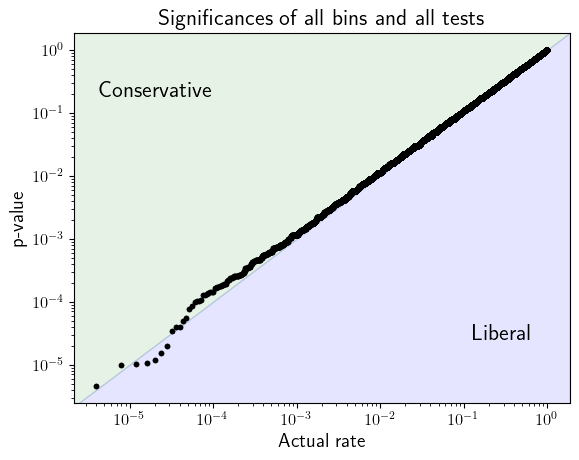

In [68]:
plt.figure()
plt.title("Significances of all bins and all tests")
plt.ylabel("p-value")
plt.xlabel("Actual rate")
plt.xscale("log")
plt.yscale("log")

sig_use = np.sort(sigs.flatten())[::-1]
sig_use = sig_use[np.isfinite(sig_use)]
counts = np.arange(1, len(sig_use)+1)
p_values = get_p_value(sig_use)

x = [1/len(sig_use), 1]
#plt.plot(x, x, color="black")
plt.scatter(counts/len(sig_use), p_values, marker = '.', color="black")
xmin, xmax = plt.xlim()
ymin, ymax = plt.ylim()
a = min([xmin, ymin])
b = max([xmax, ymax])
plt.fill_between([a,b],[a,b], [b,b], alpha=0.1, color="green")
plt.fill_between([a,b],[a,a], [a,b], alpha=0.1, color="blue")
plt.text(xmin*2, ymax/10, "Conservative", size=16)
plt.text(xmax/15, ymin*10, "Liberal", size=16)
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
plt.scatter(counts/len(sig_use), p_values, marker = '.', color="black")



Lastly, we take the max of all bins within one drawing from the dataset, i.e. performing multiple trials per dataset. We use the Bonferroni Correction and multiply the p-value by the total number of bins. This is a conservative correction as can be seen in the plot.

250000
(10000,)


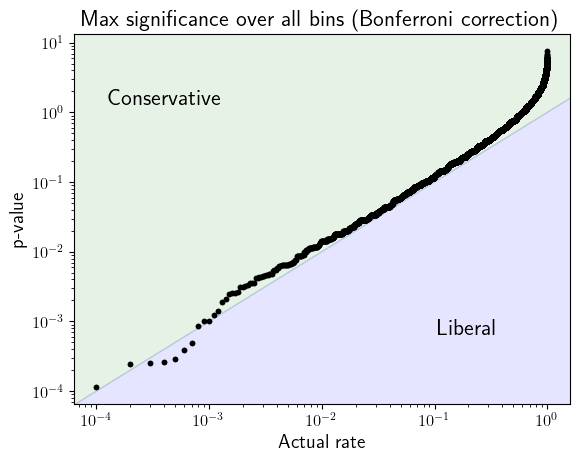

In [70]:
plt.figure()
plt.title("Max significance over all bins (Bonferroni correction)")
plt.ylabel("p-value")
plt.xlabel("Actual rate")
plt.xscale("log")
plt.yscale("log")

print(np.sum(np.isfinite(sigs)))
sig_use = np.sort(np.max(sigs, axis=(0,1)))[::-1]
print(sig_use.shape)
trial_factor = bins*bins
sig_use = sig_use[np.isfinite(sig_use)]
counts = np.arange(1, len(sig_use)+1)
p_values = get_p_value(sig_use)*trial_factor

plt.scatter(counts/len(sig_use), p_values, marker = '.', color="black")
xmin, xmax = plt.xlim()
ymin, ymax = plt.ylim()
a = min([xmin, ymin])
b = max([xmax, ymax])
plt.fill_between([a,b],[a,b], [b,b], alpha=0.1, color="green")
plt.fill_between([a,b],[a,a], [a,b], alpha=0.1, color="blue")
plt.text(xmin*2, ymax/10, "Conservative", size=16)
plt.text(xmax/15, ymin*10, "Liberal", size=16)
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
plt.scatter(counts/len(sig_use), p_values, marker = '.', color="black")

In [ ]:
N_tests = 10000
N = 100000
p = 1e-3

exp = np.zeros((N_tests))
obs = np.zeros((N_tests))
rv = multivariate_normal([0,0], [[1,0],[0,1]])

labels = np.append(np.zeros(N), np.ones(N))
np.random.shuffle(labels)

for k in tqdm.tqdm(range(N_tests)):
    data = rv.rvs(size=N*2)
    inds = np.arange(len(data))
    split = np.array_split(inds,2)
    tree = HistGradientBoostingClassifier(validation_fraction=0.5)
    tree.fit(data[split[0]], labels[split[0]])
    preds = tree.predict_proba(data[split[1]])[:,1]
    labels_test = labels[split[1]]
    R_C = np.quantile(preds[labels_test==0], p, interpolation="nearest")
    exp[k] = np.sum(preds[labels_test==0]>R_C)
    obs[k] = np.sum(preds[labels_test==1]>R_C)
sigs_tree = significance_formula(obs, exp)


100%|██████████| 1000/1000 [01:39<00:00, 10.09it/s]


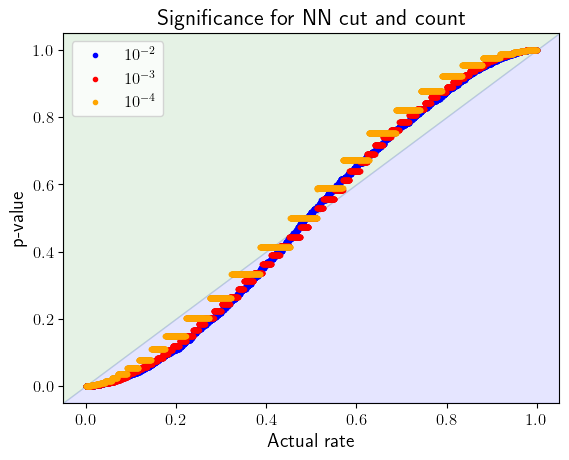

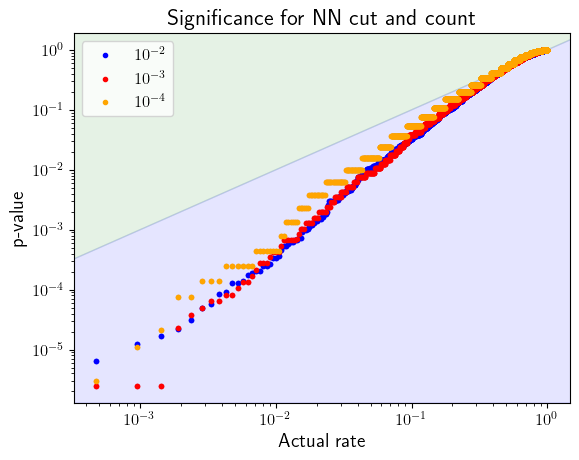

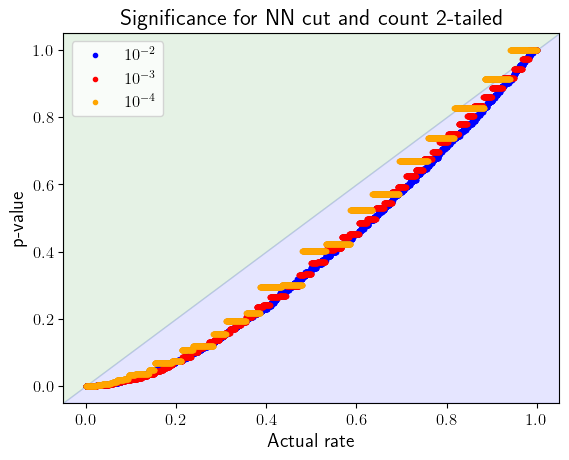

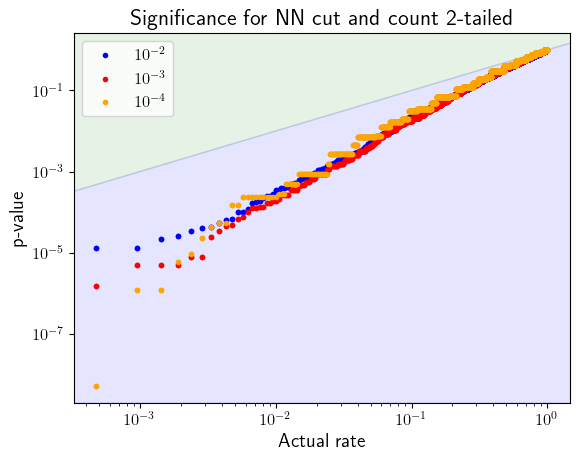

In [29]:
folder = "/hpcwork/zu992399/look_elsewhere/NN_calibration/"
N_samples_after = np.load(folder+"N_samples_after.npy")
N_samples = np.load(folder+"N_samples.npy")
N_after = np.load(folder+"N_after.npy")
N = np.load(folder+"N.npy")
k=0.5

p1 = np.sort(p_value_poissonpoisson(N_after[:,0], N_samples_after[:,0]/N_samples[:,0]*N[:,0], k=k))
p2 = np.sort(p_value_poissonpoisson(N_after[:,1], N_samples_after[:,1]/N_samples[:,1]*N[:,1], k=k))
p3 = np.sort(p_value_poissonpoisson(N_after[:,2], N_samples_after[:,2]/N_samples[:,2]*N[:,2], k=k))

#Plot for max of bins
plt.figure()
plt.title("Significance for NN cut and count")
plt.ylabel("p-value")
plt.xlabel("Actual rate")
#plt.xscale("log")
#plt.yscale("log")

trials = len(N)
counts = np.arange(1, trials+1)

plt.scatter(counts/trials, p1, marker = '.', color="blue")
plt.scatter(counts/trials, p2, marker = '.', color="red")
plt.scatter(counts/trials, p3, marker = '.', color="orange")
xmin, xmax = plt.xlim()
ymin, ymax = plt.ylim()
a = min([xmin, ymin])
b = max([xmax, ymax])
plt.fill_between([a,b],[a,b], [b,b], alpha=0.1, color="green")
plt.fill_between([a,b],[a,a], [a,b], alpha=0.1, color="blue")
#plt.text(xmin*2, ymax/10, "Conservative", size=16)
#plt.text(xmax/15, ymin*10, "Liberal", size=16)
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)


plt.scatter(counts/trials, p1, marker = '.', color="blue", label=r"$10^{-2}$")
plt.scatter(counts/trials, p2, marker = '.', color="red", label=r"$10^{-3}$")
plt.scatter(counts/trials, p3, marker = '.', color="orange", label=r"$10^{-4}$")
plt.legend()
plt.savefig("plots/NN_test.png")


#Plot for max of bins
plt.figure()
plt.title("Significance for NN cut and count")
plt.ylabel("p-value")
plt.xlabel("Actual rate")
plt.xscale("log")
plt.yscale("log")

trials = len(N)
counts = np.arange(1, trials+1)

plt.scatter(counts/trials, p1, marker = '.', color="blue")
plt.scatter(counts/trials, p2, marker = '.', color="red")
plt.scatter(counts/trials, p3, marker = '.', color="orange")
xmin, xmax = plt.xlim()
ymin, ymax = plt.ylim()
a = min([xmin, ymin])
b = max([xmax, ymax])
plt.fill_between([a,b],[a,b], [b,b], alpha=0.1, color="green")
plt.fill_between([a,b],[a,a], [a,b], alpha=0.1, color="blue")
#plt.text(xmin*2, ymax/10, "Conservative", size=16)
#plt.text(xmax/15, ymin*10, "Liberal", size=16)
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)


plt.scatter(counts/trials, p1, marker = '.', color="blue", label=r"$10^{-2}$")
plt.scatter(counts/trials, p2, marker = '.', color="red", label=r"$10^{-3}$")
plt.scatter(counts/trials, p3, marker = '.', color="orange", label=r"$10^{-4}$")
plt.legend()
plt.savefig("plots/NN_test.png")


p1 = np.sort(p_value_poissonpoisson_2tailed(N_after[:,0], N_samples_after[:,0]/N_samples[:,0]*N[:,0], k=k))
p2 = np.sort(p_value_poissonpoisson_2tailed(N_after[:,1], N_samples_after[:,1]/N_samples[:,1]*N[:,1], k=k))
p3 = np.sort(p_value_poissonpoisson_2tailed(N_after[:,2], N_samples_after[:,2]/N_samples[:,2]*N[:,2], k=k))

#Plot for max of bins
plt.figure()
plt.title("Significance for NN cut and count 2-tailed")
plt.ylabel("p-value")
plt.xlabel("Actual rate")
#plt.xscale("log")
#plt.yscale("log")

trials = len(N)
counts = np.arange(1, trials+1)

plt.scatter(counts/trials, p1, marker = '.', color="blue")
plt.scatter(counts/trials, p2, marker = '.', color="red")
plt.scatter(counts/trials, p3, marker = '.', color="orange")
xmin, xmax = plt.xlim()
ymin, ymax = plt.ylim()
a = min([xmin, ymin])
b = max([xmax, ymax])
plt.fill_between([a,b],[a,b], [b,b], alpha=0.1, color="green")
plt.fill_between([a,b],[a,a], [a,b], alpha=0.1, color="blue")
#plt.text(xmin*2, ymax/10, "Conservative", size=16)
#plt.text(xmax/15, ymin*10, "Liberal", size=16)
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)


plt.scatter(counts/trials, p1, marker = '.', color="blue", label=r"$10^{-2}$")
plt.scatter(counts/trials, p2, marker = '.', color="red", label=r"$10^{-3}$")
plt.scatter(counts/trials, p3, marker = '.', color="orange", label=r"$10^{-4}$")
plt.legend()
plt.savefig("plots/NN_test.png")


#Plot for max of bins
plt.figure()
plt.title("Significance for NN cut and count 2-tailed")
plt.ylabel("p-value")
plt.xlabel("Actual rate")
plt.xscale("log")
plt.yscale("log")

trials = len(N)
counts = np.arange(1, trials+1)

plt.scatter(counts/trials, p1, marker = '.', color="blue")
plt.scatter(counts/trials, p2, marker = '.', color="red")
plt.scatter(counts/trials, p3, marker = '.', color="orange")
xmin, xmax = plt.xlim()
ymin, ymax = plt.ylim()
a = min([xmin, ymin])
b = max([xmax, ymax])
plt.fill_between([a,b],[a,b], [b,b], alpha=0.1, color="green")
plt.fill_between([a,b],[a,a], [a,b], alpha=0.1, color="blue")
#plt.text(xmin*2, ymax/10, "Conservative", size=16)
#plt.text(xmax/15, ymin*10, "Liberal", size=16)
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)


plt.scatter(counts/trials, p1, marker = '.', color="blue", label=r"$10^{-2}$")
plt.scatter(counts/trials, p2, marker = '.', color="red", label=r"$10^{-3}$")
plt.scatter(counts/trials, p3, marker = '.', color="orange", label=r"$10^{-4}$")
plt.legend()
plt.savefig("plots/NN_test.png")

[   0    1    2 ... 2097 2098 2099]


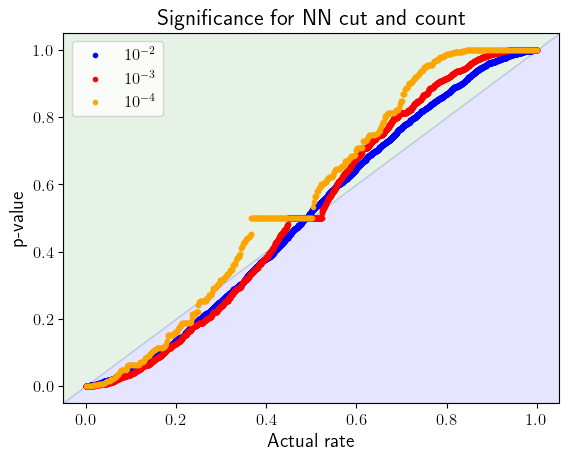

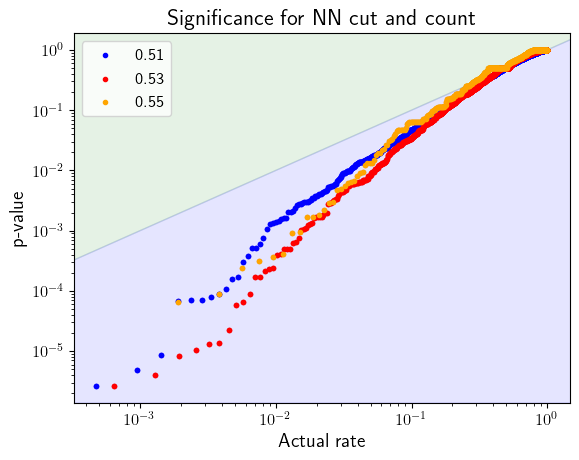

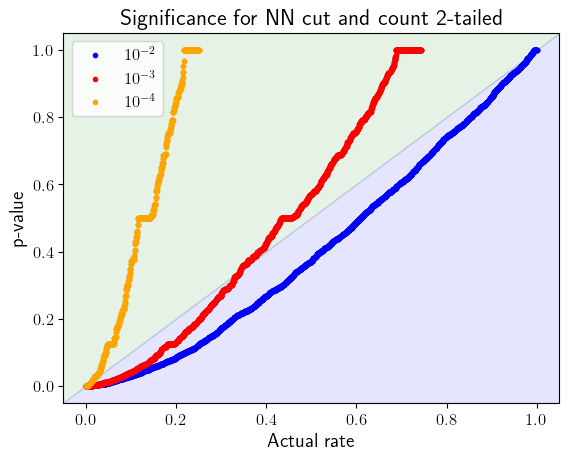

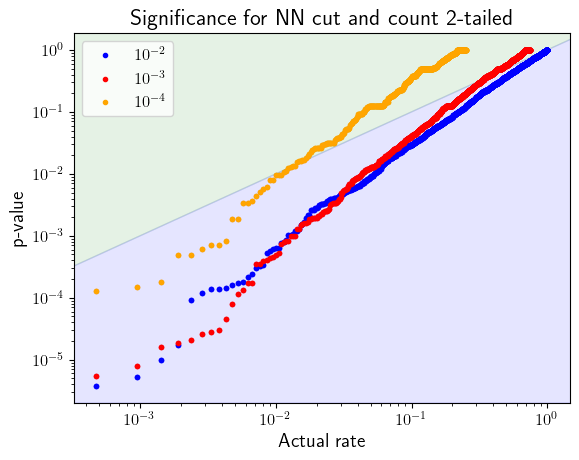

In [ ]:
folder = "/hpcwork/zu992399/look_elsewhere/NN_calibration/"
N_samples_after = np.load(folder+"N_samples_after_fixed.npy")
N_samples = np.load(folder+"N_samples.npy")
N_after = np.load(folder+"N_after_fixed.npy")
N = np.load(folder+"N.npy")
k=0.5

inds1 = np.nonzero(N_samples_after[:,0])[0]
print(inds1)
p1 = np.sort(p_value_poissonpoisson(N_after[inds1,0], N_samples_after[inds1,0]/N_samples[inds1,0]*N[inds1,0], k=k))
inds2 = np.nonzero(N_samples_after[:,1])[0]
p2 = np.sort(p_value_poissonpoisson(N_after[inds2,1], N_samples_after[inds2,1]/N_samples[inds2,1]*N[inds2,1], k=k))
inds3 = np.nonzero(N_samples_after[:,2])[0]
p3 = np.sort(p_value_poissonpoisson(N_after[inds3,2], N_samples_after[inds3,2]/N_samples[inds3,2]*N[inds3,2], k=k))

#Plot for max of bins
plt.figure()
plt.title("Significance for NN cut and count")
plt.ylabel("p-value")
plt.xlabel("Actual rate")
#plt.xscale("log")
#plt.yscale("log")

trials1 = len(inds1)
counts1 = np.arange(1, trials1+1)

trials2 = len(inds2)
counts2 = np.arange(1, trials2+1)

trials3 = len(inds3)
counts3 = np.arange(1, trials3+1)


plt.scatter(counts1/trials1, p1, marker = '.', color="blue")
plt.scatter(counts2/trials2, p2, marker = '.', color="red")
plt.scatter(counts3/trials3, p3, marker = '.', color="orange")
xmin, xmax = plt.xlim()
ymin, ymax = plt.ylim()
a = min([xmin, ymin])
b = max([xmax, ymax])
plt.fill_between([a,b],[a,b], [b,b], alpha=0.1, color="green")
plt.fill_between([a,b],[a,a], [a,b], alpha=0.1, color="blue")
#plt.text(xmin*2, ymax/10, "Conservative", size=16)
#plt.text(xmax/15, ymin*10, "Liberal", size=16)
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)


plt.scatter(counts1/trials1, p1, marker = '.', color="blue", label=r"$10^{-2}$")
plt.scatter(counts2/trials2, p2, marker = '.', color="red", label=r"$10^{-3}$")
plt.scatter(counts3/trials3, p3, marker = '.', color="orange", label=r"$10^{-4}$")
plt.legend()
plt.savefig("plots/NN_test.png")


#Plot for max of bins
plt.figure()
plt.title("Significance for NN cut and count")
plt.ylabel("p-value")
plt.xlabel("Actual rate")
plt.xscale("log")
plt.yscale("log")

trials = len(N)
counts = np.arange(1, trials+1)

plt.scatter(counts1/trials1, p1, marker = '.', color="blue")
plt.scatter(counts2/trials2, p2, marker = '.', color="red")
plt.scatter(counts3/trials3, p3, marker = '.', color="orange")
xmin, xmax = plt.xlim()
ymin, ymax = plt.ylim()
a = min([xmin, ymin])
b = max([xmax, ymax])
plt.fill_between([a,b],[a,b], [b,b], alpha=0.1, color="green")
plt.fill_between([a,b],[a,a], [a,b], alpha=0.1, color="blue")
#plt.text(xmin*2, ymax/10, "Conservative", size=16)
#plt.text(xmax/15, ymin*10, "Liberal", size=16)
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)


plt.scatter(counts1/trials1, p1, marker = '.', color="blue", label="0.51")
plt.scatter(counts2/trials2, p2, marker = '.', color="red", label="0.53")
plt.scatter(counts3/trials3, p3, marker = '.', color="orange", label="0.55")
plt.legend()
plt.savefig("plots/NN_test.png")


p1 = np.sort(p_value_poissonpoisson_2tailed(N_after[:,0], N_samples_after[:,0]/N_samples[:,0]*N[:,0], k=k))
p2 = np.sort(p_value_poissonpoisson_2tailed(N_after[:,1], N_samples_after[:,1]/N_samples[:,1]*N[:,1], k=k))
p3 = np.sort(p_value_poissonpoisson_2tailed(N_after[:,2], N_samples_after[:,2]/N_samples[:,2]*N[:,2], k=k))

#Plot for max of bins
plt.figure()
plt.title("Significance for NN cut and count 2-tailed")
plt.ylabel("p-value")
plt.xlabel("Actual rate")
#plt.xscale("log")
#plt.yscale("log")

trials = len(N)
counts = np.arange(1, trials+1)

plt.scatter(counts/trials, p1, marker = '.', color="blue")
plt.scatter(counts/trials, p2, marker = '.', color="red")
plt.scatter(counts/trials, p3, marker = '.', color="orange")
xmin, xmax = plt.xlim()
ymin, ymax = plt.ylim()
a = min([xmin, ymin])
b = max([xmax, ymax])
plt.fill_between([a,b],[a,b], [b,b], alpha=0.1, color="green")
plt.fill_between([a,b],[a,a], [a,b], alpha=0.1, color="blue")
#plt.text(xmin*2, ymax/10, "Conservative", size=16)
#plt.text(xmax/15, ymin*10, "Liberal", size=16)
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)


plt.scatter(counts/trials, p1, marker = '.', color="blue", label=r"$10^{-2}$")
plt.scatter(counts/trials, p2, marker = '.', color="red", label=r"$10^{-3}$")
plt.scatter(counts/trials, p3, marker = '.', color="orange", label=r"$10^{-4}$")
plt.legend()
plt.savefig("plots/NN_test.png")


#Plot for max of bins
plt.figure()
plt.title("Significance for NN cut and count 2-tailed")
plt.ylabel("p-value")
plt.xlabel("Actual rate")
plt.xscale("log")
plt.yscale("log")

trials = len(N)
counts = np.arange(1, trials+1)

plt.scatter(counts/trials, p1, marker = '.', color="blue")
plt.scatter(counts/trials, p2, marker = '.', color="red")
plt.scatter(counts/trials, p3, marker = '.', color="orange")
xmin, xmax = plt.xlim()
ymin, ymax = plt.ylim()
a = min([xmin, ymin])
b = max([xmax, ymax])
plt.fill_between([a,b],[a,b], [b,b], alpha=0.1, color="green")
plt.fill_between([a,b],[a,a], [a,b], alpha=0.1, color="blue")
#plt.text(xmin*2, ymax/10, "Conservative", size=16)
#plt.text(xmax/15, ymin*10, "Liberal", size=16)
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)


plt.scatter(counts/trials, p1, marker = '.', color="blue", label=r"$10^{-2}$")
plt.scatter(counts/trials, p2, marker = '.', color="red", label=r"$10^{-3}$")
plt.scatter(counts/trials, p3, marker = '.', color="orange", label=r"$10^{-4}$")
plt.legend()
plt.savefig("plots/NN_test.png")

10000
(1000,)


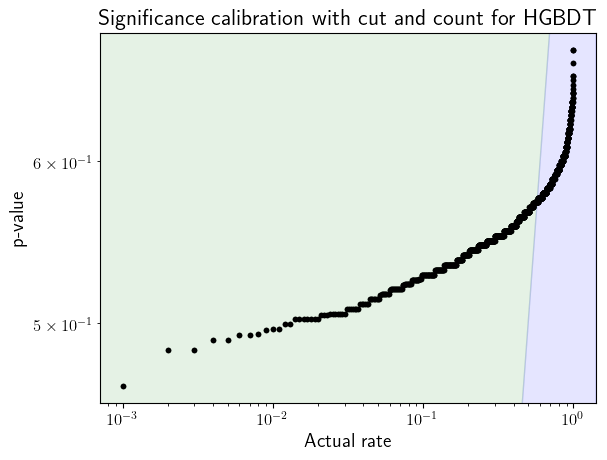

In [21]:
plt.figure()
plt.title("Significance calibration with cut and count for HGBDT")
plt.ylabel("p-value")
plt.xlabel("Actual rate")
plt.xscale("log")
plt.yscale("log")

print(np.sum(np.isfinite(sigs)))
sig_use = np.sort(sigs_tree)[::-1]
print(sig_use.shape)
sig_use = sig_use[np.isfinite(sig_use)]
counts = np.arange(1, len(sig_use)+1)
#trial_factor=256*256
p_values = get_p_value(sig_use)#*trial_factor

plt.scatter(counts/len(sig_use), p_values, marker = '.', color="black")
xmin, xmax = plt.xlim()
ymin, ymax = plt.ylim()
a = min([xmin, ymin])
b = max([xmax, ymax])
plt.fill_between([a,b],[a,b], [b,b], alpha=0.1, color="green")
plt.fill_between([a,b],[a,a], [a,b], alpha=0.1, color="blue")
#plt.text(xmin*2, ymax/10, "Conservative", size=16)
#plt.text(xmax/15, ymin*10, "Liberal", size=16)
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
plt.scatter(counts/len(sig_use), p_values, marker = '.', color="black")